## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

## 1. Import libraries

In [1]:
# Upgrade tensorflow to use Grad-Cam
!pip install -U tensorflow==2.11
%load_ext autoreload
%autoreload 2

Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: tensorflow==2.11 in /root/.local/lib/python3.7/site-packages (2.11.0)


In [2]:
import os
import random

import keras
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats
import tensorflow as tf

from glob import glob
from itertools import chain

from IPython.display import Image, display
from keras.applications.vgg16 import VGG16
# from keras.applications.resnet import ResNet50 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from keras.metrics import Precision, Recall
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from skimage import filters
from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve, average_precision_score,
    RocCurveDisplay, classification_report, ConfusionMatrixDisplay,
    confusion_matrix
)
from sklearn.model_selection import train_test_split
from typing import Tuple

%matplotlib inline
sns.set_style('white')
plt.rc("axes.spines", top=False, right=False)

print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.11.0


## 2. Data loading

In [3]:
# Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')

# Read full image filepaths into a dataframe for easier manipulation
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
88357,00021860_008.png,Effusion,8,21860,47,F,AP,3056,2544,0.139,0.139,NaN,/data/images_010/images/00021860_008.png
91031,00022690_001.png,No Finding,1,22690,21,F,PA,2992,2991,0.143,0.143,NaN,/data/images_010/images/00022690_001.png
69264,00017098_006.png,No Finding,6,17098,68,F,PA,2992,2991,0.143,0.143,NaN,/data/images_008/images/00017098_006.png


In [4]:
print(f'Number of entries: {all_xray_df.shape[0]:,.0f}')
print(f'Number of unique images: {all_xray_df["Image Index"].nunique():,.0f}')
print(f'Number of unique patients: {all_xray_df["Patient ID"].nunique():,.0f}')
print(f'Number of unique labels: {all_xray_df["Finding Labels"].nunique():,.0f}')
print(f'Number of unique genders: {all_xray_df["Patient Gender"].nunique():,.0f}')
print(f'Number of unique view positions: {all_xray_df["View Position"].nunique():,.0f}')

Number of entries: 112,120
Number of unique images: 112,120
Number of unique patients: 30,805
Number of unique labels: 836
Number of unique genders: 2
Number of unique view positions: 2


## 3. Data preprocessing

### 3.1. Data cleaning

In [5]:
outliers_age = all_xray_df[all_xray_df['Patient Age'] > 100]
print('Number of outliers with age > 100 years old:', outliers_age.shape[0])
outliers_age

Number of outliers with age > 100 years old: 16


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
20852,00005567_000.png,Effusion|Pneumonia,0,5567,412,M,AP,3056,2544,0.139,0.139,NaN,/data/images_003/images/00005567_000.png
46965,00011973_002.png,Edema,2,11973,414,M,AP,3056,2544,0.139,0.139,NaN,/data/images_006/images/00011973_002.png
48284,00012238_010.png,No Finding,10,12238,148,M,PA,2992,2991,0.143,0.143,NaN,/data/images_006/images/00012238_010.png
55742,00013950_000.png,No Finding,0,13950,148,M,PA,2964,2939,0.143,0.143,NaN,/data/images_007/images/00013950_000.png
58650,00014520_026.png,Infiltration|Mass,26,14520,150,M,PA,2992,2991,0.143,0.143,NaN,/data/images_007/images/00014520_026.png
62929,00015558_000.png,No Finding,0,15558,149,M,PA,2992,2991,0.143,0.143,NaN,/data/images_007/images/00015558_000.png
74884,00018366_044.png,Pneumothorax,44,18366,152,F,PA,2302,2991,0.143,0.143,NaN,/data/images_008/images/00018366_044.png
78795,00019346_000.png,Infiltration,0,19346,151,F,PA,2678,2774,0.143,0.143,NaN,/data/images_009/images/00019346_000.png
84810,00020900_002.png,No Finding,2,20900,411,M,AP,3056,2544,0.139,0.139,NaN,/data/images_009/images/00020900_002.png
85404,00021047_002.png,Mass|Pleural_Thickening,2,21047,412,M,AP,3056,2544,0.139,0.139,NaN,/data/images_010/images/00021047_002.png


In [6]:
all_xray_df = all_xray_df.drop(columns='Unnamed: 11')
# Drop outliers with ages higher than 100 years old to avoid biases
# Reason: There are just 16 entries out of 112,120
all_xray_df = all_xray_df.loc[all_xray_df['Patient Age'] <= 100].copy()

### 3.2. Label pre-processing

In [7]:
## Add binary indicators for diseases 
entry_findings = all_xray_df['Finding Labels'].map(lambda x: x.split('|'))
all_diseases = set(chain.from_iterable(entry_findings.tolist()))

diseases = pd.DataFrame(index=all_xray_df.index)
for disease in all_diseases:
    diseases[disease] = all_xray_df['Finding Labels'].map(lambda x: disease in x)

diseases = diseases.astype(np.int64)
all_xray_df = pd.concat([all_xray_df, diseases], axis=1)
all_xray_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Nodule,Atelectasis,Pneumonia,Hernia,Edema,Consolidation,Cardiomegaly,Fibrosis,Pneumothorax,Pleural_Thickening
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0,0,0,0,0,0,1,0,0,0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0,0,0,0,0,0,1,0,0,0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0,0,0,0,0,0,1,0,0,0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0,0,0,0,0,0,0,0,0,0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,...,0,0,1,0,0,0,0,0,0,0
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,...,0,0,0,0,0,0,0,0,0,0
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,...,0,0,0,0,0,0,0,0,0,0
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,...,0,0,0,0,0,0,0,0,0,0


In [8]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification
all_xray_df['pneumonia_class'] = np.where(all_xray_df['Pneumonia'], 'pneumonia', 'no_pneumonia')
all_xray_df['pneumonia_class'].value_counts()

no_pneumonia    110674
pneumonia         1430
Name: pneumonia_class, dtype: int64

### 3.3. Data splitting

In [9]:
def undersample(df: pd.DataFrame, target_col: str, ratio_pneumonia: float) -> pd.DataFrame:
    ''' Randomly undersample a DataFrame according to the target column
    
    The sampling strategy is defined to 0.5 so that the samples with the
    target class represent half of the dataset used for training.
    
    Alternatives: 
    https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html
    '''
    neg_ratio = int(1 / ratio_pneumonia - 1)
    
    pos_indexes = df.loc[df[target_col] == 'pneumonia'].index.tolist()
    neg_indexes = df.loc[df[target_col] == 'no_pneumonia'].index.tolist()

    neg_samples = random.sample(neg_indexes, neg_ratio * len(pos_indexes))
    return df.loc[pos_indexes + neg_samples].copy()
    

def remove_overlap(patients_train, val_data):
    patients_val = set(val_data['Patient ID'].unique())
    overlap_ids = list(patients_val.intersection(patients_train))
    print(f'{len(overlap_ids)} patients in both datasets')
    print('Dropping those patients from the target set\n')
    overlap_idx = val_data.query('`Patient ID` in @overlap_ids').index
    val_data = val_data.drop(overlap_idx)    
    return val_data
    
    
def create_splits(
    df: pd.DataFrame, 
    test_size: float, 
    stratify: str) -> Tuple[pd.DataFrame, pd.DataFrame]:
    ''' Splits the data into training and validation sets.
    
    It applies an undersampling strategy for the training set.
    The validation set represents the prevalence of the target class
    on the target population.
    '''
    # Separate 20% for the final evaluation
    dev_data, test_data = train_test_split(
        df, 
        test_size=test_size,
        shuffle=True,
        stratify=df[stratify],
        random_state=0,
    )
    
    # Separate the development set in 80/20 (train/val)
    train_data, val_data = train_test_split(
        dev_data, 
        test_size=test_size,
        shuffle=True,
        stratify=dev_data[stratify], 
        random_state=0,
    )    
    
    # 50% of the images in the training set with Pneumonia
    train_data = undersample(train_data, 'pneumonia_class', ratio_pneumonia=0.5)
    
    # Avoid data leakage in the validation set by removing patients
    # considered in the training set
    # Alternative: StratifiedGroupKFold (not available on this environment)
    patients_train = set(train_data['Patient ID'].unique())
    val_data = remove_overlap(patients_train, val_data)    
    
    # 20% of the images in the validation set with Pneumonia
    val_data = undersample(val_data, 'pneumonia_class', ratio_pneumonia=0.2)
    
    # Avoid data leakage in the test set
    patients_val = set(val_data['Patient ID'].unique())
    patients_dev = patients_train.union(patients_val)
    test_data = remove_overlap(patients_dev, test_data)
    test_data = undersample(test_data, 'pneumonia_class', ratio_pneumonia=0.2)
    
    return train_data, val_data, test_data

In [10]:
train_df, val_df, test_df = create_splits(df=all_xray_df, test_size=0.2, stratify='pneumonia_class')

print('Class distribution in the training set:')
print(train_df.pneumonia_class.value_counts(normalize=False))
print(train_df.pneumonia_class.value_counts(normalize=True))

print('\nClass distribution in the validation set:')
print(val_df.pneumonia_class.value_counts(normalize=False))
print(val_df.pneumonia_class.value_counts(normalize=True))

print('\nClass distribution in the test set:')
print(test_df.pneumonia_class.value_counts(normalize=False))
print(test_df.pneumonia_class.value_counts(normalize=True))

917 patients in both datasets
Dropping those patients from the target set

1359 patients in both datasets
Dropping those patients from the target set

Class distribution in the training set:
no_pneumonia    915
pneumonia       915
Name: pneumonia_class, dtype: int64
no_pneumonia    0.5
pneumonia       0.5
Name: pneumonia_class, dtype: float64

Class distribution in the validation set:
no_pneumonia    524
pneumonia       131
Name: pneumonia_class, dtype: int64
no_pneumonia    0.8
pneumonia       0.2
Name: pneumonia_class, dtype: float64

Class distribution in the test set:
no_pneumonia    572
pneumonia       143
Name: pneumonia_class, dtype: int64
no_pneumonia    0.8
pneumonia       0.2
Name: pneumonia_class, dtype: float64


## 4. Model training

### 4.1. Data augmentation

In [11]:
TRAIN_BATCH_SIZE = 32
VAL_BATCH_SIZE = 128

def img_size_vgg16():
    '''Return the img size used as input by VGG16'''
    return (224, 224)


def my_image_augmentation_train_set():    
    return ImageDataGenerator(rescale=1./255.0,
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range = 0.1, 
                              width_shift_range = 0.1, 
                              rotation_range = 10, 
                              shear_range = 0.1,
                              zoom_range = 0.1,
                             )

def image_augmentation_val_set():
    return ImageDataGenerator(rescale=1./255.0)


def make_train_gen(df):
    '''Create image generators for the training data'''
    generator = my_image_augmentation_train_set()
    return generator.flow_from_dataframe(dataframe=df, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'pneumonia_class',
                                         class_mode = 'binary',
                                         target_size = img_size_vgg16(),
                                         batch_size = TRAIN_BATCH_SIZE,
                                         shuffle=True,
                                         )
    return train_gen


def make_val_gen(df):
    '''Create image generators for the validation data'''
    generator = image_augmentation_val_set()
    val_gen = generator.flow_from_dataframe(dataframe=df, 
                                            directory=None, 
                                            x_col = 'path',
                                            y_col = 'pneumonia_class',
                                            class_mode = 'binary',
                                            shuffle=False,
                                            target_size = img_size_vgg16(), 
                                            batch_size = VAL_BATCH_SIZE) 
    return val_gen

In [12]:
def plot_sample(x, y):
    '''Look at some examples of the data'''
    fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
    for (c_x, c_y, c_ax) in zip(x, y, m_axs.flatten()):
        c_ax.imshow(c_x[:,:,0], cmap = 'bone')
        if c_y == 1: 
            c_ax.set_title('Pneumonia')
        else:
            c_ax.set_title('No Pneumonia')
        c_ax.axis('off')

Found 655 validated image filenames belonging to 2 classes.


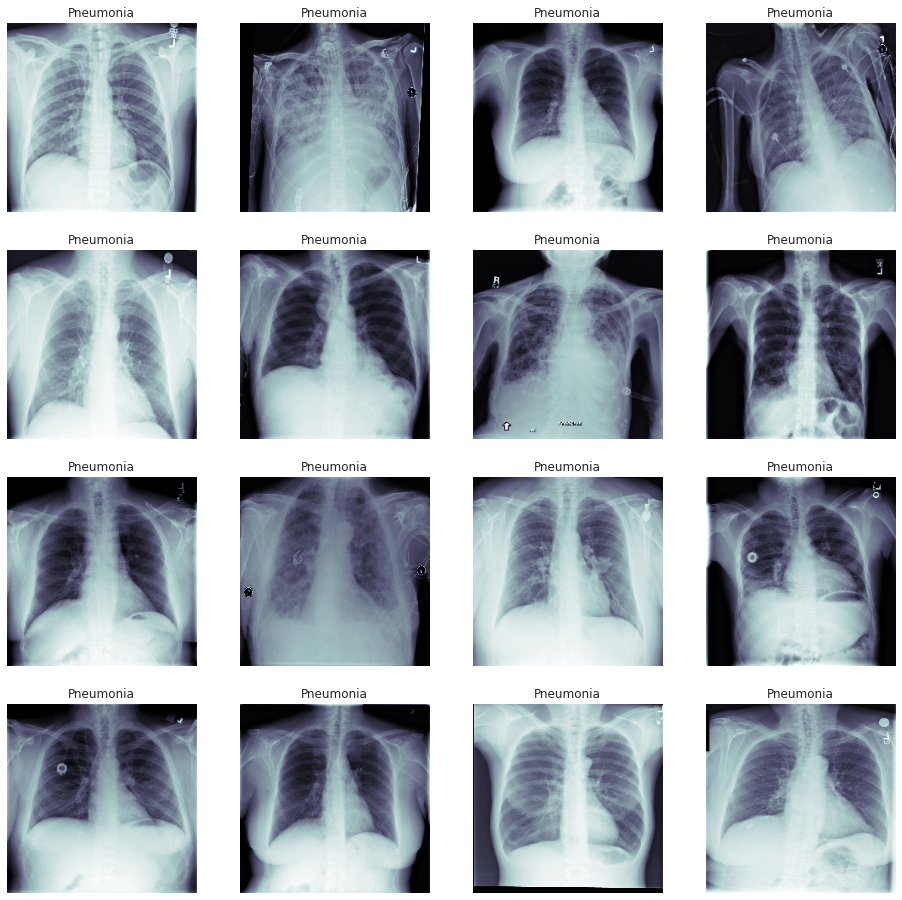

In [13]:
## Pull a single large batch of random validation data for testing after each epoch:
val_gen = make_val_gen(val_df)
X_val, y_val = val_gen.next()
plot_sample(X_val, y_val)

Found 1830 validated image filenames belonging to 2 classes.


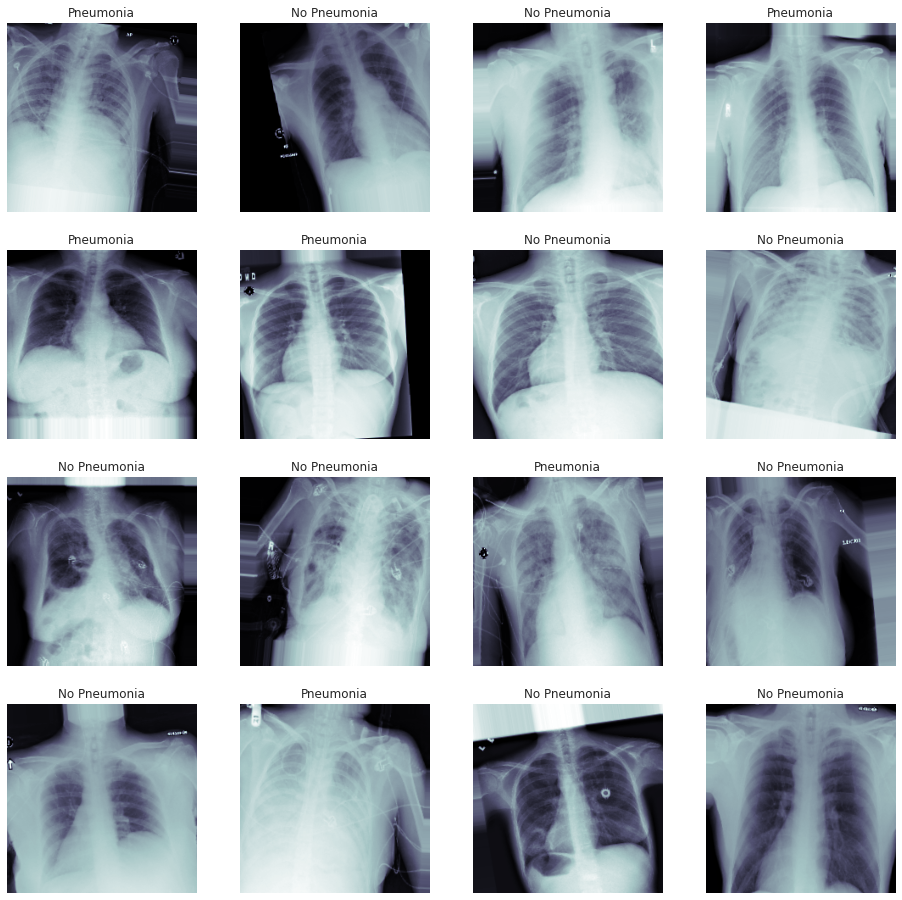

In [40]:
train_gen = make_train_gen(train_df)
X_train, y_train = next(train_gen)
plot_sample(X_train, y_train)

### 4.2. Model building

In [14]:
def load_pretrained_vgg16_model():
    model = VGG16(include_top=False, weights='imagenet', input_shape=(224,224,3))
    vgg_model = Model(inputs=model.input, outputs=model.output)
    
    # Freeze all but the last convolutional layer
    for layer in vgg_model.layers[:17]:
        layer.trainable = False

    print('Layers:')
    for layer in vgg_model.layers:
        print(layer.name, layer.trainable)

    return vgg_model

In [48]:
def build_my_model():
    
    my_model = Sequential()    
    base_model = load_pretrained_vgg16_model()
    x = tf.keras.layers.Flatten()(base_model.output)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    my_model = tf.keras.models.Model(base_model.input , outputs)

#     my_model = Sequential()    
#     vgg_model = load_pretrained_vgg16_model()    
#     my_model.add(vgg_model)

#     my_model.add(Flatten())    
#     my_model.add(Dense(512, activation='relu'))
#     my_model.add(Dropout(0.4))
#     my_model.add(Dense(64, activation='relu'))
#     my_model.add(Dropout(0.4))
#     my_model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(lr=1e-4)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy', Recall()]    
    
    my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return my_model

In [49]:
weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor='loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min', 
                             save_weights_only=True)

early = EarlyStopping(monitor='loss', 
                      mode='min', 
                      patience=10)

callbacks_list = [checkpoint, early]

In [50]:
my_model = build_my_model()
my_model.summary()

Layers:
input_2 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 True
block5_pool True
Model: "model_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                               

### 4.3. Train model

In [45]:
history = my_model.fit(train_gen, 
                        validation_data=val_gen, 
                        epochs=50,
                        callbacks=callbacks_list)

Epoch 1/50
58/58 [==============================] - 72s 1s/step - loss: 0.7393 - binary_accuracy: 0.5180 - recall_1: 0.5301 - val_loss: 0.5399 - val_binary_accuracy: 0.7936 - val_recall_1: 0.0400

Epoch 00001: loss improved from inf to 0.73848, saving model to xray_class_my_model.best.hdf5
Epoch 2/50
58/58 [==============================] - 52s 892ms/step - loss: 0.6932 - binary_accuracy: 0.5454 - recall_1: 0.5301 - val_loss: 0.7198 - val_binary_accuracy: 0.4576 - val_recall_1: 0.7840

Epoch 00002: loss improved from 0.73848 to 0.69378, saving model to xray_class_my_model.best.hdf5
Epoch 3/50
58/58 [==============================] - 55s 949ms/step - loss: 0.6877 - binary_accuracy: 0.5607 - recall_1: 0.5803 - val_loss: 0.5953 - val_binary_accuracy: 0.6784 - val_recall_1: 0.4000

Epoch 00003: loss improved from 0.69378 to 0.68548, saving model to xray_class_my_model.best.hdf5
Epoch 4/50
58/58 [==============================] - 55s 941ms/step - loss: 0.6807 - binary_accuracy: 0.5689 - rec


Epoch 00029: loss did not improve from 0.51809
Epoch 30/50
58/58 [==============================] - 55s 951ms/step - loss: 0.5137 - binary_accuracy: 0.7481 - recall_1: 0.7322 - val_loss: 0.4685 - val_binary_accuracy: 0.6656 - val_recall_1: 0.5360

Epoch 00030: loss improved from 0.51809 to 0.51299, saving model to xray_class_my_model.best.hdf5
Epoch 31/50
58/58 [==============================] - 55s 954ms/step - loss: 0.4896 - binary_accuracy: 0.7634 - recall_1: 0.7738 - val_loss: 0.5284 - val_binary_accuracy: 0.6528 - val_recall_1: 0.5600

Epoch 00031: loss improved from 0.51299 to 0.49169, saving model to xray_class_my_model.best.hdf5
Epoch 32/50
58/58 [==============================] - 55s 948ms/step - loss: 0.4904 - binary_accuracy: 0.7628 - recall_1: 0.7607 - val_loss: 0.7109 - val_binary_accuracy: 0.5488 - val_recall_1: 0.6560

Epoch 00032: loss improved from 0.49169 to 0.48707, saving model to xray_class_my_model.best.hdf5
Epoch 33/50
58/58 [==============================] - 55

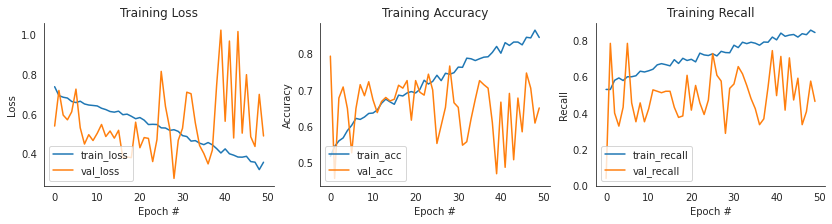

<Figure size 432x288 with 0 Axes>

In [47]:
def plot_history(history):
    _, ax = plt.subplots(1, 3, figsize=(14, 3))
    N = len(history.history["loss"])
    plt.figure()
    ax[0].plot(np.arange(0, N), history.history["loss"], label="train_loss")
    ax[0].plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    
    ax[1].plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    ax[1].plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    
    ax[2].plot(np.arange(0, N), history.history["recall_1"], label="train_recall")
    ax[2].plot(np.arange(0, N), history.history["val_recall_1"], label="val_recall")    
    
    ax[0].set_title("Training Loss")
    ax[0].set_ylabel("Loss")
    ax[1].set_title("Training Accuracy")
    ax[1].set_ylabel("Accuracy")    
    ax[2].set_title("Training Recall")
    ax[2].set_ylabel("Recall")    
    for axis in ax:
        axis.set_xlabel("Epoch #")
        axis.legend(loc="lower left")
    
    
plot_history(history);

At Epoch 28, the model seems to be getting an optimal fitting in terms of loss, accuracy, and recall. After that point, overfitting starts taking place, with training metrics getting better though with unstable validation metrics.

### 4.4. Evaluate model performance

In [51]:
# Note that detecting pneumonia is hard even for trained expert radiologists
my_model.load_weights(weight_path)

val_gen.reset()
y_val = val_gen.classes
y_scores = my_model.predict(val_gen, verbose=True)

ValueError: Layer count mismatch when loading weights from file. Model expected 16 layers, found 4 saved layers.

In [22]:
def plot_auc(y_true, y_scores):
    '''Plot the RoC curve
    
    Ref: https://scikit-learn.org/0.22/modules/generated/sklearn.metrics.RocCurveDisplay.html
    '''
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='')
    display.plot()


def plot_precision_recall_curve(y_true, y_scores):
    _, ax = plt.subplots()
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    avg_score = average_precision_score(y_true,y_scores)
    ax.plot(recall, precision, label=f'Average score: {avg_score:.2f}')
    ax.legend()
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')    
    plt.show()
    return precision, recall, thresholds


def f1_score(precision, recall):
    return 2*(precision*recall)/(precision+recall)    

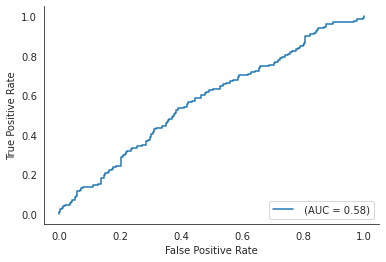

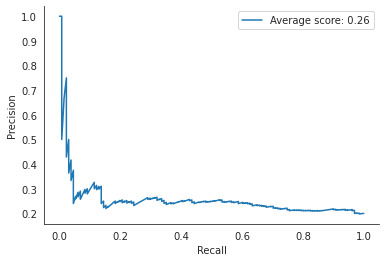

In [23]:
plot_auc(y_val, y_scores)

precision, recall, thresholds = plot_precision_recall_curve(y_val, y_scores)

### 4.5. Fine tune classification threshold

#### 4.5.1. Find the optimal threshold

In [24]:
# Find the threshold that optimize the model's performance

recall_value = 0.9
idx = (np.abs(recall - recall_value)).argmin() 
print('Precision is: '+ str(precision[idx]))
print('Recall is: '+ str(recall[idx]))
print('Threshold is: '+ str(thresholds[idx]))
print('F1 Score is: ' + str(f1_score(precision[idx],recall[idx])))

Precision is: 0.21493624772313297
Recall is: 0.9007633587786259
Threshold is: 0.068479635
F1 Score is: 0.34705882352941175


Precision is: 0.2153846153846154
Recall is: 0.9618320610687023
Threshold is: 0.03718342
F1 Score is: 0.3519553072625698
Max F1 score: 0.3519553072625698


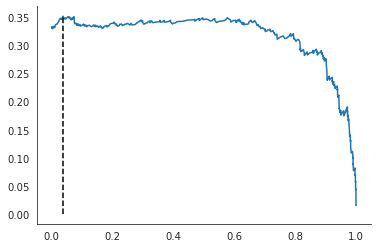

In [25]:
# Find the argmax F1 score
f1_scores = np.nan_to_num(f1_score(precision, recall), 0)[:-1]
idx = np.argmax(f1_scores)
best_threshold = thresholds[idx]
print('Precision is: '+ str(precision[idx]))
print('Recall is: '+ str(recall[idx]))
print('Threshold is: '+ str(best_threshold))
print('F1 Score is: ' + str(f1_score(precision[idx],recall[idx])))
print('Max F1 score:', f1_scores.max())

x = thresholds
y = f1_scores
_, ax = plt.subplots()
ax.plot(x, y)
ax.plot([thresholds[idx], thresholds[idx]], [0, max(y)], 'k--')

#### 4.5.2. Classification metrics on the validation set

              precision    recall  f1-score   support

   pneumonia       0.21      0.95      0.35       131
no_pneumonia       0.92      0.12      0.22       524

    accuracy                           0.29       655
   macro avg       0.56      0.54      0.28       655
weighted avg       0.78      0.29      0.24       655



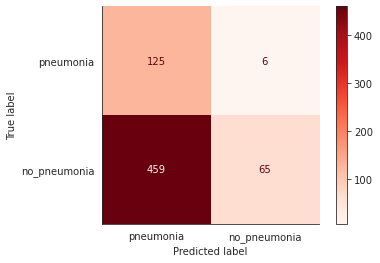

In [34]:
def classification_metrics(y_true, y_pred):
    labels = ['pneumonia', 'no_pneumonia']
    print(classification_report(y_true, y_pred, labels=[1, 0], target_names=labels))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1, 0])
    disp = ConfusionMatrixDisplay(cm, display_labels=labels)
    disp.plot(cmap='Reds', values_format='')
    

y_pred_val = (y_scores > best_threshold).astype(int)
classification_metrics(y_val, y_pred_val)

128.0


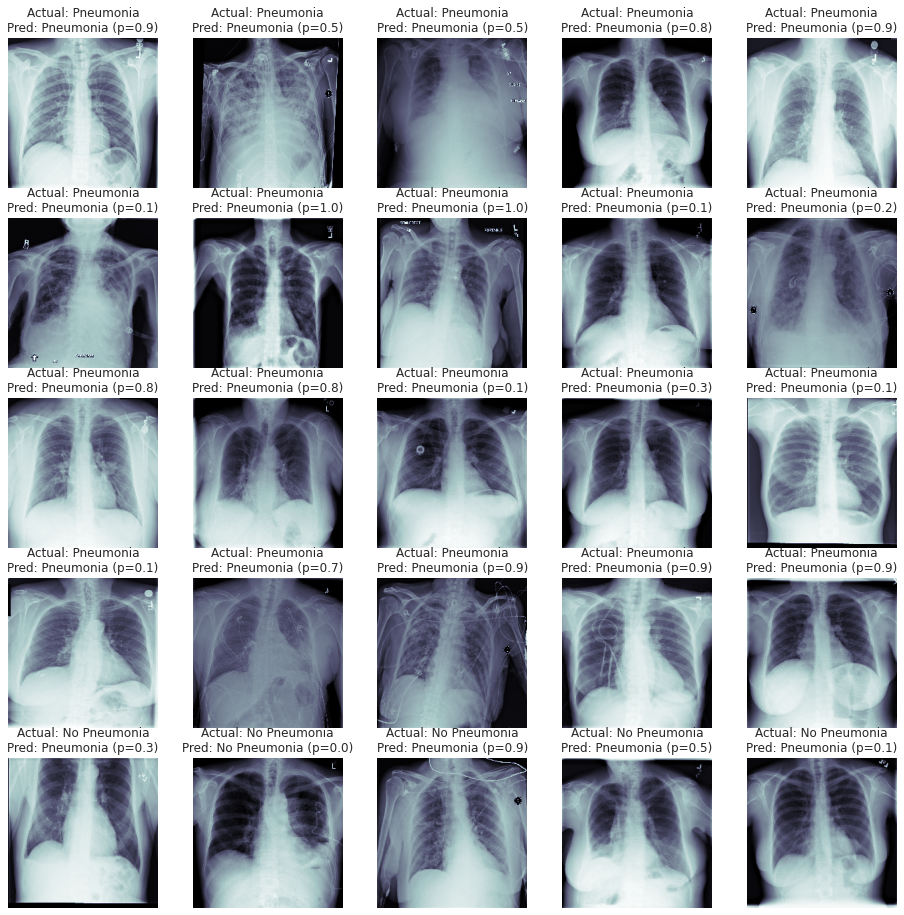

In [41]:
# Let's look at some examples of true vs. predicted with our best model
def show_images_with_pred(gen, y_scores, thresh):
    fig, m_axs = plt.subplots(5, 5, figsize = (16, 16))
    i = 0
    n_pos = 0
    X, y = gen.next()
    for (c_x, c_y, c_ax) in zip(X[0:25], y[0:25], m_axs.flatten()):
        c_ax.imshow(c_x[:,:,0], cmap = 'bone')
        score = float(y_scores[i])
        if c_y == 1 and n_pos <20: 
            n_pos += 1
            if score > thresh:
                c_ax.set_title(f'Actual: Pneumonia\nPred: Pneumonia (p={score:.1f})')
            else:
                c_ax.set_title(f'Actual: Pneumonia\nPred: No Pneumonia (p={score:.1f})')
        else:
            if score > thresh: 
                c_ax.set_title(f'Actual: No Pneumonia\nPred: Pneumonia (p={score:.1f})')
            else:
                c_ax.set_title(f'Actual: No Pneumonia\nPred: No Pneumonia (p={score:.1f})')
        c_ax.axis('off')
        i=i+1

        
show_images_with_pred(val_gen, y_scores, best_threshold)

#### 4.5.3. Observe the model focus on cases with Pneumonia

1/1 [==============================] - 1s 1s/step


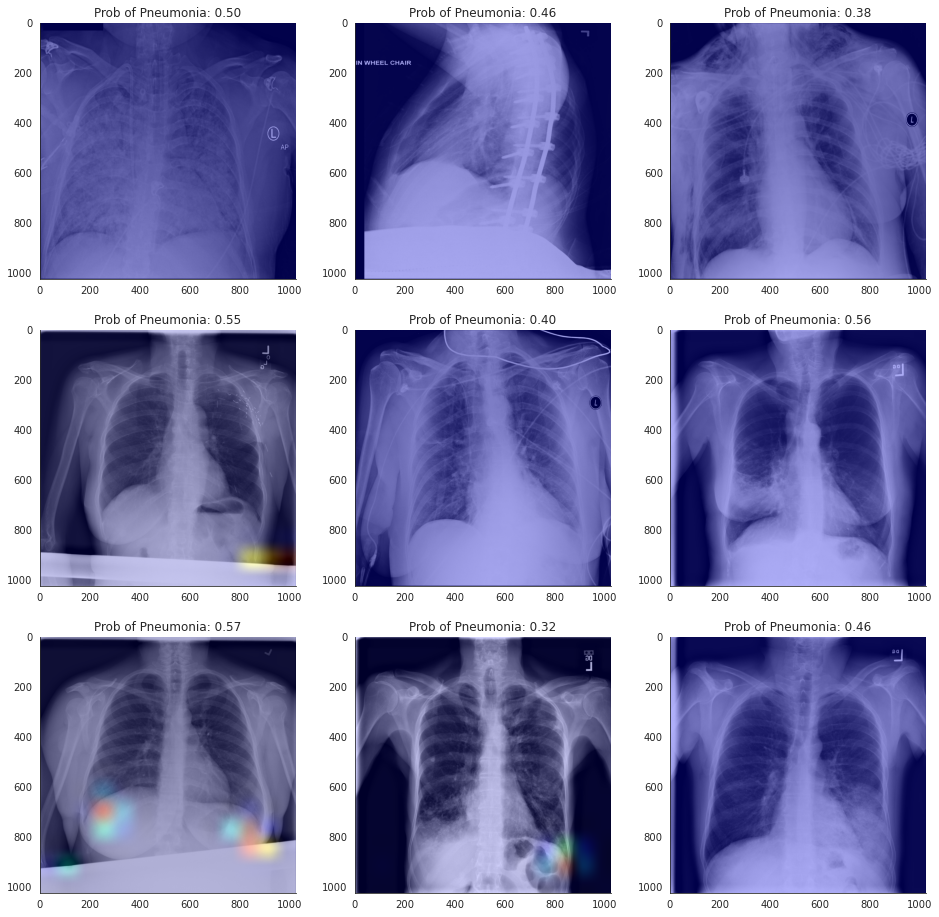

In [82]:
# https://keras.io/examples/vision/grad_cam/
def get_img_array(img_path, size):
    # `img` is a PIL image of size 224x224
    img = tf.keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (224, 224, 3)
    array = tf.keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 224, 224, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )
    y_pneumonia = model.output[0][0]
    
    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
                pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


def display_gradcam(img_path, heatmap, ax, prob, alpha=0.4):
    # Load the original image
    img = tf.keras.utils.load_img(img_path)
    img = tf.keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Display Grad CAM
    ax.imshow(superimposed_img)
    ax.set_title(f'Prob of Pneumonia: {prob[0]:.2f}')


def show_img_with_grad_cam(img_path, ax):
    img_size = img_size_vgg16()
    preprocess_input = tf.keras.applications.vgg16.preprocess_input
    decode_predictions = tf.keras.applications.vgg16.decode_predictions
    last_conv_layer_name = "block5_conv3"

    # Prepare image
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    img_array = img_array / 255.0

    # Make model
    model = my_model

    # Remove last layer's softmax
    model.layers[-1].activation = None

    # Print what the top predicted class is
    preds = model.predict(img_array)
    prob = np.exp(preds[0])

    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    display_gradcam(img_path, heatmap, ax, prob)
    
    

samples_with_pneumonia = val_df.query('pneumonia_class == "pneumonia"').sample(16)
fig, m_axs = plt.subplots(3, 3, figsize = (16, 16))
i = 0
n_pos = 0
X = samples_with_pneumonia
y = samples_with_pneumonia.pneumonia_class

# for (c_x, c_y, c_ax) in zip(X[0:16], y[0:16], m_axs.flatten()):
for sample, c_ax in zip(samples_with_pneumonia.iterrows(), m_axs.flatten()):
    idx, sample_val = sample
    img_path = sample_val.path
    show_img_with_grad_cam(img_path, c_ax)

### 5. Model evaluation

In [ ]:
test_gen = make_val_gen(test_df)
y_test = test_gen.classes
y_scores_test = my_model.predict(test_gen, verbose=True)
y_pred_test = y_scores_test > best_threshold

plot_auc(y_test, y_scores_test)
precision, recall, thresholds = plot_precision_recall_curve(y_test, y_scores_test)

In [ ]:
classification_metrics(y_test, y_pred_test)

In [ ]:
show_images_with_pred(test_gen, y_pred_test)

In [26]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)